## QuasarNET Performance vs dll
#### Plot to show performance of QuasarNET as a function of the QN wavelength grid separation
xxx

In [8]:
import astropy
import copy
import glob
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [9]:
figsize = (12,6.5)
fontsize = 18

temp_output_loc = '/global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/'

plt.rc('font', size=fontsize)

### Load the results from the different QN models

In [10]:
## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True
common_specids = True

In [11]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [12]:
data = {}

for dll in variables.DLL_VALUES:
    
    ## Load the QN using nchunks value.
    f_qn = glob.glob(variables.OUTDIR+'/outputs/qn_outputs/additional_setups/dll_values/dll_{}/qnAll*.fits'.format(dll))[0]
    data['QN_{}'.format(dll)] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [13]:
data_table = utils.reduce_data_to_table(data,truth,include_c_qn=include_c_qn,common_specids=False)
data_table[:5]

SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_QN_0.002,CLASS_QN_0.002,ISQSO_QN_0.002,C_QN_0.002 [6],Z_QN_0.001,CLASS_QN_0.001,ISQSO_QN_0.001,C_QN_0.001 [6],Z_QN_0.0005,CLASS_QN_0.0005,ISQSO_QN_0.0005,C_QN_0.0005 [6]
int64,int64,int64,float64,str8,bool,float64,str8,bool,float64,float64,str8,bool,float64,float64,str8,bool,float64
7166566020362,20589337,2,1.616,QSO,True,1.612,QSO,True,0.001 .. 0.000,1.618,QSO,True,0.000 .. 0.000,1.147,NONQSO,False,0.000 .. 0.000
7166566020367,20603085,2,2.070,QSO,True,2.062,QSO,True,0.994 .. 0.000,2.076,QSO,True,0.966 .. 0.000,2.033,QSO,True,0.987 .. 0.000
7169566280047,20935261,2,0.000,STAR,False,1.289,NONQSO,False,0.000 .. 0.000,1.014,NONQSO,False,0.000 .. 0.000,3.041,NONQSO,False,0.000 .. 0.000
7169566280046,20935742,2,0.000,STAR,False,0.565,NONQSO,False,0.000 .. 0.000,2.916,NONQSO,False,0.000 .. 0.000,1.286,NONQSO,False,0.000 .. 0.000
7169566280052,20936956,2,0.000,STAR,False,1.275,NONQSO,False,0.000 .. 0.000,2.375,NONQSO,False,0.000 .. 0.000,1.312,NONQSO,False,0.000 .. 0.000


In [14]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
len(data_table)

506016

### Compare the performance of the different model/data combos.
xxx

In [15]:
ls = {'QN_0.001': '-',
      'QN_0.002': '--',
      'QN_0.0005': ':',
     }

In [16]:
## Define general parameter values.
dv_max = 6000.

# confidence thresholds.
c_th_min = 0.0
c_th_max = 1.0
n_int = 100
c_th_values = np.linspace(c_th_min,c_th_max,n_int)

In [17]:
## Define strategies.
strategies = {}

for s in data.keys():
    
    nchunks = float(s.split('_')[-1])
    name = r'$n_{{boxes}}={}$'.format(nchunks)
    if type(data_table['ISQSO_{}'.format(s)])==astropy.table.column.MaskedColumn:
        filt = (~data_table['ISQSO_{}'.format(s)].data.mask)
    else:
        filt = np.ones(len(data_table)).astype(bool)
    
    # QN definitions.
    n_detect = 1
    strat = strategy.Strategy('qn',cf_kwargs={'qn_name':s})
    preds = [strat.predict(data_table,filter=filt,c_kwargs={'c_th':c_th_value,'n_detect':n_detect}) for c_th_value in c_th_values]
    strategies[s] = {'isqso': [pred.isqso for pred in preds],
                     'z': [pred.z for pred in preds],
                     'c_th': c_th_values,
                     'n': name, 
                     'ls': ls[s]}

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/numpy/ma/core.py:4036: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = compare(sdata, odata)
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:34: RuntimeWarning: invalid value encountered in long_scalars
  pur = pur_num/pur_denom
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:266: RuntimeWarning: invalid value encountered in greater
  ind = np.where(pur>com)[0][0]
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Strategy QN_0.002:
Crossover occurs at:
cth: [0.2828 0.2929 0.303  0.3131]
pur: [0.9924 0.9924 0.9925 0.9926]
com: [0.9925 0.9925 0.9924 0.9924]
QN_0.002 has median velocity error -69.223 and standard deviation 805.283

Strategy QN_0.001:
Crossover occurs at:
cth: [0.101  0.1111 0.1212 0.1313]
pur: [0.9935 0.9937 0.9937 0.9938]
com: [0.9937 0.9937 0.9936 0.9936]
QN_0.001 has median velocity error 67.883 and standard deviation 779.030

Strategy QN_0.0005:
Crossover occurs at:
cth: [0.0404 0.0505 0.0606 0.0707]
pur: [0.9905 0.991  0.9913 0.9916]
com: [0.9912 0.991  0.9909 0.9908]
QN_0.0005 has median velocity error 41.653 and standard deviation 1050.048



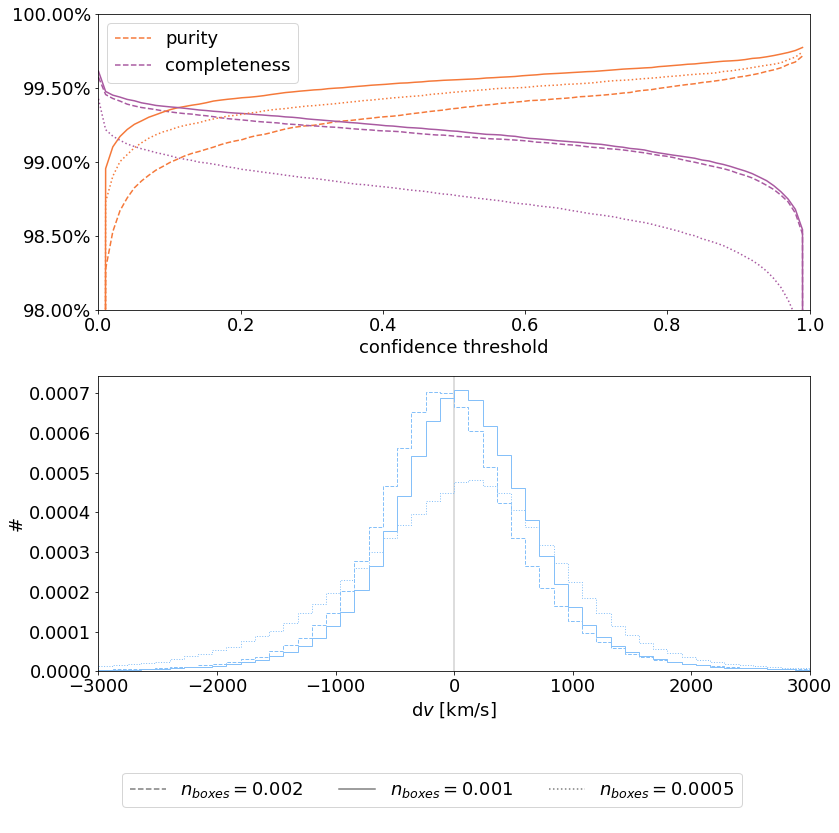

In [18]:
filename = '../plots/qn_performance_vs_dll.pdf'

plot.plot_qn_model_compare(data_table,strategies,filename=filename,
                           dv_max=dv_max,nydec=2,figsize=(12,12),
                           ymin=0.98,ymax=1.,verbose=True,npanel=2,
                           norm_dvhist=True)
plt.show()